# Review Data from TransparentCalifornia

In [1]:
import sys
!{sys.executable} -m pip install pandas matplotlib ipywidgets scipy pandas_profiling > /dev/null
!{sys.executable} -m pip install genderize gender_guesser seaborn statsmodels datadotworld[pandas] > /dev/null

import requests
from io import StringIO
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib
%matplotlib inline
from genderize import Genderize
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import datadotworld as dw


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fetch data from publicpay.ca.gov
df = None
for year in range(2011,2020):    
    year_df = pd.read_csv(f'state-of-california-{year}.csv.zip', compression='zip',
                           usecols=['Employee Name', 'Job Title', 'Year', 'Base Pay'])
    year_df = year_df[year_df['Base Pay'].ne('Not Provided')]
    year_df['Base Pay'] = pd.to_numeric(year_df['Base Pay']).astype('float64')
    year_df['Job Title'] = year_df['Job Title'].str.upper().str.strip()
    year_df['Employee Name'] = year_df['Employee Name'].str.title()
    print(f'Year {year} Rows {len(year_df)}')
    df = year_df if df is None else df.append(year_df)

Year 2011 Rows 246599
Year 2012 Rows 244881
Year 2013 Rows 235071
Year 2014 Rows 240531
Year 2015 Rows 246273


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Year 2016 Rows 248272
Year 2017 Rows 247697
Year 2018 Rows 253503
Year 2019 Rows 260277


In [3]:
print(df.dtypes)

Employee Name     object
Job Title         object
Base Pay         float64
Year               int64
dtype: object


### Profiling Report (Disabled)

In [4]:
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile

### Top 20 Job Titles

<AxesSubplot:>

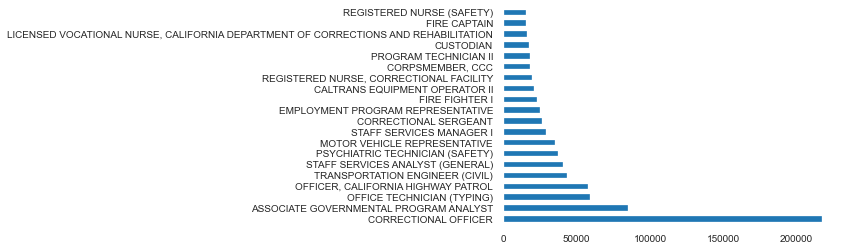

In [5]:
df['Job Title'].value_counts()[0:20].plot(kind='barh')

# Compute Genders

In [6]:
df['First Name'] = df['Employee Name'].str.split(n=2).str[0]

In [7]:
d = gender.Detector()
df['Gender'] = df['First Name'].apply(lambda name: d.get_gender(name.title()))


# Rate limited, so let's not use this for now
# Genderize().get(df['First Name'])

In [8]:
df[['First Name', 'Gender']][0:100]

,First Name,Gender
0,Mohammad,male
1,Gertrudis,female
2,Joseph,male
3,Thomas,male
4,Curtis,male
...,...,...
95,Michael,male
96,Theodore,male
97,Dennis,male
98,Wadsworth,unknown


### Gender Distribution

<AxesSubplot:>

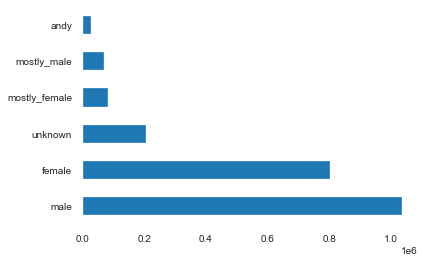

In [9]:
df['Gender'].value_counts()[0:100].plot(kind='barh')

In [10]:
mean_salary_df = df.groupby(['Job Title', 'Gender'])['Base Pay'].mean()

In [11]:
mean_salary_df

Job Title                                             Gender       
02                                                    female           42839.492000
                                                      male             35332.539412
                                                      mostly_female    26698.620000
                                                      mostly_male      30393.350000
                                                      unknown          45501.950000
                                                                           ...     
YOUTHFUL OFFENDER PAROLE BOARD REPRESENTATIVE         female           63537.600000
                                                      male              4451.966923
                                                      mostly_female    99319.388571
ZERO EMISSION VEHICLE INFRASTRUCTURE PROJECT MANAGER  male             75332.842000
ZERO EMISSION VEHICLE POLICY ADVISOR TO THE CHAIR     male             85492.640000
Name: Ba

### Check on Duplicates
Remove any employee name that appears in a year more than once.

@TODO Review whether this step is necessary or not

In [12]:
dupes_df = df.groupby(['Year', 'Employee Name'])['Base Pay'].count()

In [13]:
dupes_df[dupes_df > 1].sort_values(ascending=False)[0:50]

Year  Employee Name              
2011   Name Withheld                 652
2016  Name Withheld Name Withheld    572
2019   Name Withheld                 569
2017  Name Withheld Name Withheld    564
2018  Name Withheld Name Withheld    562
2015  Name Withheld Name Withheld    555
2012   Name Withheld                 547
2014  Name Withheld Name Withheld    526
2013  Name Withheld Name Withheld    495
2019  Amandeep Kaur                   12
2018  Mandeep Kaur                    11
      Amandeep Kaur                   11
2019  Mandeep Kaur                    11
2017  Mandeep Kaur                    10
2016  Jose L Hernandez                 9
2015  Jose L Hernandez                 9
2014  Daniel Garcia                    9
2012  Daniel Garcia                    9
2017  Amandeep Kaur                    8
2011  Daniel Garcia                    8
2016  David Rodriguez                  8
2017  Daniel Lopez                     8
2013  Patricia Garcia                  8
2019  Jose Ramirez     

### Look at distributions

In [14]:
from scipy import stats
import ipywidgets as widgets

In [15]:
popular_jobs_df = df.groupby(['Job Title'], as_index=False)['Employee Name'] \
    .count() \
    .rename(columns={"Employee Name": "Count"}) \
    .sort_values(["Count"], ascending=False)

In [16]:
popular_jobs_df

,Job Title,Count
1365,CORRECTIONAL OFFICER,217781
536,ASSOCIATE GOVERNMENTAL PROGRAM ANALYST,84940
3344,OFFICE TECHNICIAN (TYPING),58947
3350,"OFFICER, CALIFORNIA HIGHWAY PATROL",57384
5150,TRANSPORTATION ENGINEER (CIVIL),43003
...,...,...
952,"CHIEF DEPUTY DIRECTOR, DIVISION OF JUVENILE JU...",1
417,"ASSISTANT SECRETARY, ECONOMIC DEVELOPMENT-SPEC...",1
418,"ASSISTANT SECRETARY, ECONOMIC DEVELOPMENT-STAK...",1
420,"ASSISTANT SECRETARY, FINANCE AND ADMINISTRATION",1


## Collapse down to one row per name

In [17]:
df['Year in Job'] = df.groupby(['Employee Name', 'Job Title'])['Year'].rank("dense", ascending=True)

grouped_df = df.groupby(['Gender', 'First Name', 'Employee Name', 'Year'], as_index=False).agg(
    total_base_pay = ('Base Pay', 'sum'), 
    job_titles = ('Job Title', lambda x: ','.join([f'"{y}"' for y in x])),
    job_count = ('Base Pay', lambda x: len(x)),
    min_year_in_job = ('Year in Job', min),
    max_year_in_job = ('Year in Job', max)    
)


### Add a year number column (based on years in the database, by employee name)

In [18]:
grouped_df['Year Number'] = grouped_df.groupby(['Employee Name'])['Year'].rank("dense", ascending=True)

In [19]:
grouped_df = grouped_df.rename(columns={
    'total_base_pay': 'Base Pay',
    'job_titles': 'Job Title',
    'job_count': 'Job Count In Year',
    'min_year_in_job': 'Min Years In Job',
    'max_year_in_job': 'Max Years in Job'
})


In [20]:
grouped_df

,Gender,First Name,Employee Name,Year,Base Pay,Job Title,Job Count In Year,Min Years In Job,Max Years in Job,Year Number
0,andy,Adarsh,Adarsh Kaur,2011,203788.91,"""DENTIST, CORRECTIONAL FACILITY""",1.0,1.0,1.0,1.0
1,andy,Adarsh,Adarsh Kaur,2012,218272.74,"""DENTIST, CORRECTIONAL FACILITY""",1.0,2.0,2.0,2.0
2,andy,Adarsh,Adarsh Kaur,2013,214853.98,"""DENTIST, CORRECTIONAL FACILITY""",1.0,3.0,3.0,3.0
3,andy,Adarsh,Adarsh Kaur,2014,237181.13,"""DENTIST, CORRECTIONAL FACILITY""",1.0,4.0,4.0,4.0
4,andy,Adarsh,Adarsh Kaur,2015,268451.75,"""SUPERVISING DENTIST, CORRECTIONAL FACILITY""",1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2164851,unknown,Zuwena,Zuwena I Lee,2016,62696.72,"""CORRECTIONAL OFFICER""",1.0,3.0,3.0,3.0
2164852,unknown,Zuwena,Zuwena I Lee,2017,69140.95,"""CORRECTIONAL OFFICER""",1.0,4.0,4.0,4.0
2164853,unknown,Zuwena,Zuwena I Lee,2018,73553.72,"""CORRECTIONAL OFFICER""",1.0,5.0,5.0,5.0
2164854,unknown,Zuwena,Zuwena I Lee,2019,83517.32,"""CORRECTIONAL COUNSELOR I""",1.0,1.0,1.0,6.0


In [21]:
grouped_df.to_csv('salary_data.csv', index=True)

## Upload to data.world

In [22]:
client = dw.api_client()
client.upload_files('fryanpan13/california-public-salary-data',files='salary_data.csv')


### Select a Job

In [23]:
job_select = widgets.Select(
    options=popular_jobs_df.sort_values(["Count"], ascending=False)["Job Title"][0:100],
)
display(job_select)

Select(options=('CORRECTIONAL OFFICER', 'ASSOCIATE GOVERNMENTAL PROGRAM ANALYST', 'OFFICE TECHNICIAN (TYPING)'…

### Plot Gender Distributions

CORRECTIONAL OFFICER


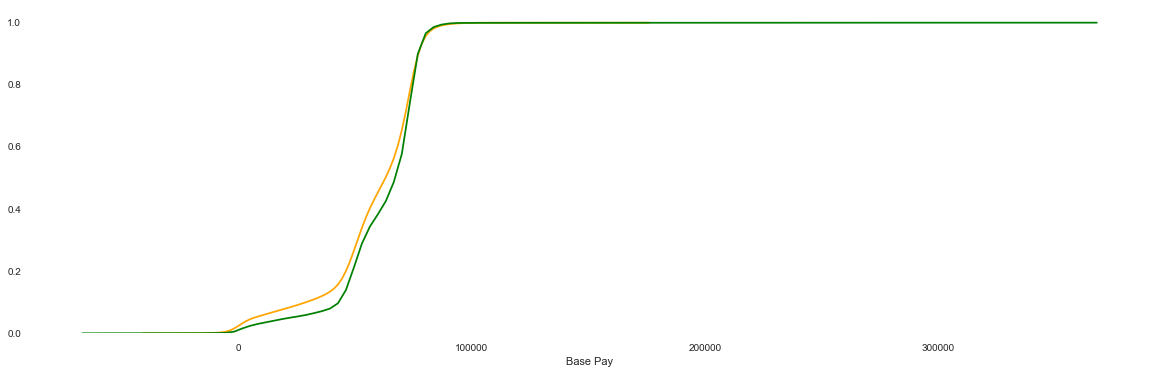

In [24]:
def plot(job_title, gender, ax, color):
    gender_df = grouped_df[(grouped_df['Job Title'] == f'"{job_title}"') & 
                           (grouped_df['Gender'] == gender) & 
                           (grouped_df['Year Number'] == 2)]
    sns.distplot(gender_df['Base Pay'], ax=ax, hist=False, kde=True, kde_kws={'cumulative': True}, color=color)
    
def update_plot(event):
    print(job_select.value)
    fig, ax = plt.subplots(figsize=(20,6))
    
    plot(job_select.value, 'female', ax, 'orange')
    plot(job_select.value, 'male', ax, 'green')
    
update_plot(5)